<a href="https://colab.research.google.com/github/MedDataInt/Drug-discovery-from-TorchDrug/blob/main/TorchDrug_Property_Prediction_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

In this tutorial, we will learn how to use TorchDrug to train a graph neural network for **molecule property prediction**. Property prediction is aimed at predicting the chemical properties of a molecule based on its graph structure and features.

### Manual Steps

1.   Get your own copy of this file via "File > Save a copy in Drive...",
2.   Set the runtime to **GPU** via "Runtime > Change runtime type..."

### Colab Tutorials

#### Quick Start
1. [Basic Usage and Pipeline](https://colab.research.google.com/drive/1Tbnr1Fog_YjkqU1MOhcVLuxqZ4DC-c8-#forceEdit=true&sandboxMode=true)

#### Drug Discovery Tasks
1. [Property Prediction](https://colab.research.google.com/drive/1sb2w3evdEWm-GYo28RksvzJ74p63xHMn?usp=sharing#forceEdit=true&sandboxMode=true)
2. [Pretrained Molecular Representations](https://colab.research.google.com/drive/10faCIVIfln20f2h1oQk2UrXiAMqZKLoW?usp=sharing#forceEdit=true&sandboxMode=true)
3. [De Novo Molecule Design](https://colab.research.google.com/drive/1JEMiMvSBuqCuzzREYpviNZZRVOYsgivA?usp=sharing#forceEdit=true&sandboxMode=true)
4. [Retrosynthesis](https://colab.research.google.com/drive/1IH1hk7K3MaxAEe5m6CFY7Eyej3RuiEL1?usp=sharing#forceEdit=true&sandboxMode=true)
5. [Knowledge Graph Reasoning](https://colab.research.google.com/drive/1-sjqQZhYrGM0HiMuaqXOiqhDNlJi7g_I?usp=sharing#forceEdit=true&sandboxMode=true)


In [1]:
import os
import torch
os.environ["TORCH_VERSION"] = torch.__version__

!pip install torch-scatter torch-cluster -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html
!pip install torchdrug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.3/267.3 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 21.9 MB/s eta 0:00:00


# Prepare the Dataset
We use ClinTox dataset for illustration. ClinTox contains 1,484 molecules labeled with FDA approvment status and toxity status in clinical trials.

Here we download the dataset and split it into training, validation and test sets. The splits for train/valid/test sets are 80%, 10% and 10% respectively.



In [2]:
import torch
from torchdrug import data, datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

INFO:torchdrug.utils.file:Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv.gz


19:33:53   Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv.gz


INFO:torchdrug.utils.file:Extracting /root/molecule-datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv


19:33:54   Extracting /root/molecule-datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv


Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.8/dist-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   1%|          | 13/1484 [00:00<00:11, 125.91it/s]/usr/local/lib/python3.8/dist-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.8/dist-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   6%|▌         | 82/1484 [00:00<00:03, 451.50it/s]/usr/local/lib/python3.8/dist-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ca`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:  1

Let’s visualize some samples from the dataset.

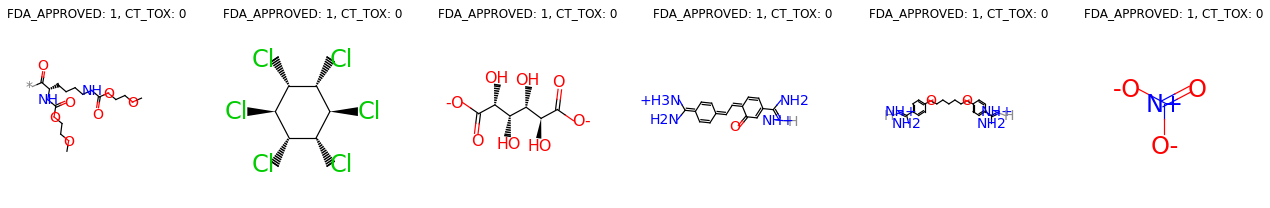

In [4]:
%matplotlib inline
graphs = []
labels = []
for i in range(6):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

# Define our Model

The model consists of two parts, a task-independent graph representation model and a task-specific module. We define a Graph Isomorphism Network (GIN) with 4 hidden layers as our representation model. The two prediction tasks will be jointly optimized through multi-task training by the task-specific module.


In [5]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

# Train and Test
Now we can train our model. We setup an optimizer for our model, and put everything together into an Engine instance. It may take a few minutes to train our model.



In [6]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1024)
solver.train(num_epoch=100)
solver.evaluate("valid")

19:35:47   Preprocess training set


 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'capturable': False,
               'class': 'optim.Adam',
               'differentiable': False,
               'eps': 1e-08,
               'foreach': None,
               'fused': False,
               'lr': 0.001,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'bce',
          'graph_construction_model': None,
          'metric': ('auprc', 'auroc'),
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'edge_input_dim': None,
                    'eps': 0,
                    'hidden_dims': [256, 256, 256, 256],
                    

19:35:51   {'batch_size': 1024,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'capturable': False,
               'class': 'optim.Adam',
               'differentiable': False,
               'eps': 1e-08,
               'foreach': None,
               'fused': False,
               'lr': 0.001,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'bce',
          'graph_construction_model': None,
          'metric': ('auprc', 'auroc'),
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'edge_input_dim': None,
                    'eps': 0,
                    'hidden_dims': [256, 256,

19:35:51   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:35:51   Epoch 0 begin


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   binary cross entropy: 4.59379


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 0 end


19:36:18   duration: 26.64 secs


19:36:18   speed: 0.08 batch / sec


19:36:18   ETA: 43.95 mins


19:36:18   max GPU memory: 735.6 MiB


19:36:18   ------------------------------


19:36:18   average binary cross entropy: 3.84129


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 1 begin


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 1 end


19:36:18   duration: 0.26 secs


19:36:18   speed: 7.78 batch / sec


19:36:18   ETA: 21.96 mins


19:36:18   max GPU memory: 753.4 MiB


19:36:18   ------------------------------


19:36:18   average binary cross entropy: 2.65198


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 2 begin


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 2 end


19:36:18   duration: 0.25 secs


19:36:18   speed: 8.07 batch / sec


19:36:18   ETA: 14.63 mins


19:36:18   max GPU memory: 744.7 MiB


19:36:18   ------------------------------


19:36:18   average binary cross entropy: 2.95919


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 3 begin


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 3 end


19:36:18   duration: 0.25 secs


19:36:18   speed: 8.07 batch / sec


19:36:18   ETA: 10.96 mins


19:36:18   max GPU memory: 748.5 MiB


19:36:18   ------------------------------


19:36:18   average binary cross entropy: 3.62793


19:36:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:18   Epoch 4 begin


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 4 end


19:36:19   duration: 0.23 secs


19:36:19   speed: 8.81 batch / sec


19:36:19   ETA: 8.74 mins


19:36:19   max GPU memory: 740.3 MiB


19:36:19   ------------------------------


19:36:19   average binary cross entropy: 3.06106


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 5 begin


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 5 end


19:36:19   duration: 0.25 secs


19:36:19   speed: 7.89 batch / sec


19:36:19   ETA: 7.28 mins


19:36:19   max GPU memory: 750.2 MiB


19:36:19   ------------------------------


19:36:19   average binary cross entropy: 2.09135


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 6 begin


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 6 end


19:36:19   duration: 0.23 secs


19:36:19   speed: 8.54 batch / sec


19:36:19   ETA: 6.22 mins


19:36:19   max GPU memory: 742.3 MiB


19:36:19   ------------------------------


19:36:19   average binary cross entropy: 2.4848


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 7 begin


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 7 end


19:36:19   duration: 0.23 secs


19:36:19   speed: 8.66 batch / sec


19:36:19   ETA: 5.43 mins


19:36:19   max GPU memory: 753.6 MiB


19:36:19   ------------------------------


19:36:19   average binary cross entropy: 1.78399


19:36:19   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:19   Epoch 8 begin


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 8 end


19:36:20   duration: 0.25 secs


19:36:20   speed: 8.12 batch / sec


19:36:20   ETA: 4.82 mins


19:36:20   max GPU memory: 742.5 MiB


19:36:20   ------------------------------


19:36:20   average binary cross entropy: 1.6171


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 9 begin


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 9 end


19:36:20   duration: 0.24 secs


19:36:20   speed: 8.28 batch / sec


19:36:20   ETA: 4.32 mins


19:36:20   max GPU memory: 746.0 MiB


19:36:20   ------------------------------


19:36:20   average binary cross entropy: 1.05473


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 10 begin


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 10 end


19:36:20   duration: 0.24 secs


19:36:20   speed: 8.32 batch / sec


19:36:20   ETA: 3.92 mins


19:36:20   max GPU memory: 751.5 MiB


19:36:20   ------------------------------


19:36:20   average binary cross entropy: 0.949159


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 11 begin


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 11 end


19:36:20   duration: 0.23 secs


19:36:20   speed: 8.78 batch / sec


19:36:20   ETA: 3.58 mins


19:36:20   max GPU memory: 750.1 MiB


19:36:20   ------------------------------


19:36:20   average binary cross entropy: 0.890923


19:36:20   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:20   Epoch 12 begin


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 12 end


19:36:21   duration: 0.23 secs


19:36:21   speed: 8.55 batch / sec


19:36:21   ETA: 3.29 mins


19:36:21   max GPU memory: 749.0 MiB


19:36:21   ------------------------------


19:36:21   average binary cross entropy: 0.463474


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 13 begin


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 13 end


19:36:21   duration: 0.24 secs


19:36:21   speed: 8.40 batch / sec


19:36:21   ETA: 3.05 mins


19:36:21   max GPU memory: 741.4 MiB


19:36:21   ------------------------------


19:36:21   average binary cross entropy: 0.492973


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 14 begin


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 14 end


19:36:21   duration: 0.24 secs


19:36:21   speed: 8.44 batch / sec


19:36:21   ETA: 2.83 mins


19:36:21   max GPU memory: 742.5 MiB


19:36:21   ------------------------------


19:36:21   average binary cross entropy: 0.574173


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 15 begin


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 15 end


19:36:21   duration: 0.24 secs


19:36:21   speed: 8.23 batch / sec


19:36:21   ETA: 2.65 mins


19:36:21   max GPU memory: 752.6 MiB


19:36:21   ------------------------------


19:36:21   average binary cross entropy: 0.514031


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:21   Epoch 16 begin


19:36:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 16 end


19:36:22   duration: 0.26 secs


19:36:22   speed: 7.74 batch / sec


19:36:22   ETA: 2.48 mins


19:36:22   max GPU memory: 743.3 MiB


19:36:22   ------------------------------


19:36:22   average binary cross entropy: 0.407285


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 17 begin


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 17 end


19:36:22   duration: 0.24 secs


19:36:22   speed: 8.37 batch / sec


19:36:22   ETA: 2.33 mins


19:36:22   max GPU memory: 749.4 MiB


19:36:22   ------------------------------


19:36:22   average binary cross entropy: 0.379058


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 18 begin


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 18 end


19:36:22   duration: 0.25 secs


19:36:22   speed: 8.16 batch / sec


19:36:22   ETA: 2.20 mins


19:36:22   max GPU memory: 742.9 MiB


19:36:22   ------------------------------


19:36:22   average binary cross entropy: 0.352744


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 19 begin


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 19 end


19:36:22   duration: 0.23 secs


19:36:22   speed: 8.60 batch / sec


19:36:22   ETA: 2.08 mins


19:36:22   max GPU memory: 746.8 MiB


19:36:22   ------------------------------


19:36:22   average binary cross entropy: 0.237878


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 20 begin


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 20 end


19:36:22   duration: 0.25 secs


19:36:22   speed: 8.11 batch / sec


19:36:22   ETA: 1.97 mins


19:36:22   max GPU memory: 745.1 MiB


19:36:22   ------------------------------


19:36:22   average binary cross entropy: 0.368441


19:36:22   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:22   Epoch 21 begin


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 21 end


19:36:23   duration: 0.23 secs


19:36:23   speed: 8.53 batch / sec


19:36:23   ETA: 1.87 mins


19:36:23   max GPU memory: 751.6 MiB


19:36:23   ------------------------------


19:36:23   average binary cross entropy: 0.430696


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 22 begin


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 22 end


19:36:23   duration: 0.24 secs


19:36:23   speed: 8.24 batch / sec


19:36:23   ETA: 1.78 mins


19:36:23   max GPU memory: 742.9 MiB


19:36:23   ------------------------------


19:36:23   average binary cross entropy: 0.300783


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 23 begin


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 23 end


19:36:23   duration: 0.25 secs


19:36:23   speed: 8.00 batch / sec


19:36:23   ETA: 1.70 mins


19:36:23   max GPU memory: 757.6 MiB


19:36:23   ------------------------------


19:36:23   average binary cross entropy: 0.262034


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 24 begin


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 24 end


19:36:23   duration: 0.24 secs


19:36:23   speed: 8.36 batch / sec


19:36:23   ETA: 1.62 mins


19:36:23   max GPU memory: 741.7 MiB


19:36:23   ------------------------------


19:36:23   average binary cross entropy: 0.218923


19:36:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:23   Epoch 25 begin


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 25 end


19:36:24   duration: 0.23 secs


19:36:24   speed: 8.62 batch / sec


19:36:24   ETA: 1.55 mins


19:36:24   max GPU memory: 749.9 MiB


19:36:24   ------------------------------


19:36:24   average binary cross entropy: 0.264212


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 26 begin


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 26 end


19:36:24   duration: 0.25 secs


19:36:24   speed: 8.04 batch / sec


19:36:24   ETA: 1.48 mins


19:36:24   max GPU memory: 743.0 MiB


19:36:24   ------------------------------


19:36:24   average binary cross entropy: 0.265425


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 27 begin


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 27 end


19:36:24   duration: 0.24 secs


19:36:24   speed: 8.42 batch / sec


19:36:24   ETA: 1.42 mins


19:36:24   max GPU memory: 742.4 MiB


19:36:24   ------------------------------


19:36:24   average binary cross entropy: 0.182619


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 28 begin


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 28 end


19:36:24   duration: 0.24 secs


19:36:24   speed: 8.29 batch / sec


19:36:24   ETA: 1.36 mins


19:36:24   max GPU memory: 757.2 MiB


19:36:24   ------------------------------


19:36:24   average binary cross entropy: 0.167445


19:36:24   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:24   Epoch 29 begin


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 29 end


19:36:25   duration: 0.24 secs


19:36:25   speed: 8.38 batch / sec


19:36:25   ETA: 1.31 mins


19:36:25   max GPU memory: 750.3 MiB


19:36:25   ------------------------------


19:36:25   average binary cross entropy: 0.18363


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 30 begin


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 30 end


19:36:25   duration: 0.25 secs


19:36:25   speed: 7.89 batch / sec


19:36:25   ETA: 1.26 mins


19:36:25   max GPU memory: 746.1 MiB


19:36:25   ------------------------------


19:36:25   average binary cross entropy: 0.208539


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 31 begin


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 31 end


19:36:25   duration: 0.24 secs


19:36:25   speed: 8.17 batch / sec


19:36:25   ETA: 1.21 mins


19:36:25   max GPU memory: 750.9 MiB


19:36:25   ------------------------------


19:36:25   average binary cross entropy: 0.175783


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 32 begin


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 32 end


19:36:25   duration: 0.25 secs


19:36:25   speed: 7.99 batch / sec


19:36:25   ETA: 1.16 mins


19:36:25   max GPU memory: 754.2 MiB


19:36:25   ------------------------------


19:36:25   average binary cross entropy: 0.147217


19:36:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:25   Epoch 33 begin


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 33 end


19:36:26   duration: 0.25 secs


19:36:26   speed: 7.94 batch / sec


19:36:26   ETA: 1.12 mins


19:36:26   max GPU memory: 740.3 MiB


19:36:26   ------------------------------


19:36:26   average binary cross entropy: 0.192139


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 34 begin


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 34 end


19:36:26   duration: 0.24 secs


19:36:26   speed: 8.30 batch / sec


19:36:26   ETA: 1.08 mins


19:36:26   max GPU memory: 751.8 MiB


19:36:26   ------------------------------


19:36:26   average binary cross entropy: 0.164097


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 35 begin


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 35 end


19:36:26   duration: 0.25 secs


19:36:26   speed: 8.09 batch / sec


19:36:26   ETA: 1.04 mins


19:36:26   max GPU memory: 745.5 MiB


19:36:26   ------------------------------


19:36:26   average binary cross entropy: 0.109958


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 36 begin


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 36 end


19:36:26   duration: 0.24 secs


19:36:26   speed: 8.45 batch / sec


19:36:26   ETA: 1.00 mins


19:36:26   max GPU memory: 748.1 MiB


19:36:26   ------------------------------


19:36:26   average binary cross entropy: 0.201172


19:36:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:26   Epoch 37 begin


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 37 end


19:36:27   duration: 0.28 secs


19:36:27   speed: 7.11 batch / sec


19:36:27   ETA: 58.14 secs


19:36:27   max GPU memory: 750.3 MiB


19:36:27   ------------------------------


19:36:27   average binary cross entropy: 0.188699


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 38 begin


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 38 end


19:36:27   duration: 0.26 secs


19:36:27   speed: 7.60 batch / sec


19:36:27   ETA: 56.15 secs


19:36:27   max GPU memory: 740.9 MiB


19:36:27   ------------------------------


19:36:27   average binary cross entropy: 0.081685


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 39 begin


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 39 end


19:36:27   duration: 0.24 secs


19:36:27   speed: 8.25 batch / sec


19:36:27   ETA: 54.21 secs


19:36:27   max GPU memory: 751.4 MiB


19:36:27   ------------------------------


19:36:27   average binary cross entropy: 0.168775


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 40 begin


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 40 end


19:36:27   duration: 0.24 secs


19:36:27   speed: 8.25 batch / sec


19:36:27   ETA: 52.36 secs


19:36:27   max GPU memory: 747.0 MiB


19:36:27   ------------------------------


19:36:27   average binary cross entropy: 0.184081


19:36:27   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:27   Epoch 41 begin


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 41 end


19:36:28   duration: 0.24 secs


19:36:28   speed: 8.46 batch / sec


19:36:28   ETA: 50.57 secs


19:36:28   max GPU memory: 751.3 MiB


19:36:28   ------------------------------


19:36:28   average binary cross entropy: 0.117514


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 42 begin


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 42 end


19:36:28   duration: 0.24 secs


19:36:28   speed: 8.29 batch / sec


19:36:28   ETA: 48.86 secs


19:36:28   max GPU memory: 750.1 MiB


19:36:28   ------------------------------


19:36:28   average binary cross entropy: 0.123718


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 43 begin


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 43 end


19:36:28   duration: 0.25 secs


19:36:28   speed: 8.12 batch / sec


19:36:28   ETA: 47.23 secs


19:36:28   max GPU memory: 740.0 MiB


19:36:28   ------------------------------


19:36:28   average binary cross entropy: 0.14306


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 44 begin


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 44 end


19:36:28   duration: 0.25 secs


19:36:28   speed: 7.91 batch / sec


19:36:28   ETA: 45.66 secs


19:36:28   max GPU memory: 739.1 MiB


19:36:28   ------------------------------


19:36:28   average binary cross entropy: 0.113696


19:36:28   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:28   Epoch 45 begin


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 45 end


19:36:29   duration: 0.24 secs


19:36:29   speed: 8.29 batch / sec


19:36:29   ETA: 44.14 secs


19:36:29   max GPU memory: 752.1 MiB


19:36:29   ------------------------------


19:36:29   average binary cross entropy: 0.102481


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 46 begin


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 46 end


19:36:29   duration: 0.23 secs


19:36:29   speed: 8.58 batch / sec


19:36:29   ETA: 42.66 secs


19:36:29   max GPU memory: 739.3 MiB


19:36:29   ------------------------------


19:36:29   average binary cross entropy: 0.0922701


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 47 begin


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 47 end


19:36:29   duration: 0.24 secs


19:36:29   speed: 8.46 batch / sec


19:36:29   ETA: 41.24 secs


19:36:29   max GPU memory: 750.6 MiB


19:36:29   ------------------------------


19:36:29   average binary cross entropy: 0.0881011


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 48 begin


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 48 end


19:36:29   duration: 0.25 secs


19:36:29   speed: 7.97 batch / sec


19:36:29   ETA: 39.89 secs


19:36:29   max GPU memory: 751.8 MiB


19:36:29   ------------------------------


19:36:29   average binary cross entropy: 0.12176


19:36:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:29   Epoch 49 begin


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 49 end


19:36:30   duration: 0.25 secs


19:36:30   speed: 8.07 batch / sec


19:36:30   ETA: 38.57 secs


19:36:30   max GPU memory: 742.5 MiB


19:36:30   ------------------------------


19:36:30   average binary cross entropy: 0.102704


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 50 begin


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   binary cross entropy: 0.0801


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 50 end


19:36:30   duration: 0.25 secs


19:36:30   speed: 7.93 batch / sec


19:36:30   ETA: 37.30 secs


19:36:30   max GPU memory: 751.5 MiB


19:36:30   ------------------------------


19:36:30   average binary cross entropy: 0.10228


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 51 begin


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 51 end


19:36:30   duration: 0.24 secs


19:36:30   speed: 8.31 batch / sec


19:36:30   ETA: 36.06 secs


19:36:30   max GPU memory: 751.6 MiB


19:36:30   ------------------------------


19:36:30   average binary cross entropy: 0.121382


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 52 begin


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 52 end


19:36:30   duration: 0.26 secs


19:36:30   speed: 7.62 batch / sec


19:36:30   ETA: 34.87 secs


19:36:30   max GPU memory: 735.1 MiB


19:36:30   ------------------------------


19:36:30   average binary cross entropy: 0.141628


19:36:30   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:30   Epoch 53 begin


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 53 end


19:36:31   duration: 0.24 secs


19:36:31   speed: 8.23 batch / sec


19:36:31   ETA: 33.71 secs


19:36:31   max GPU memory: 749.2 MiB


19:36:31   ------------------------------


19:36:31   average binary cross entropy: 0.117177


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 54 begin


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 54 end


19:36:31   duration: 0.24 secs


19:36:31   speed: 8.39 batch / sec


19:36:31   ETA: 32.57 secs


19:36:31   max GPU memory: 750.2 MiB


19:36:31   ------------------------------


19:36:31   average binary cross entropy: 0.12495


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 55 begin


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 55 end


19:36:31   duration: 0.24 secs


19:36:31   speed: 8.46 batch / sec


19:36:31   ETA: 31.46 secs


19:36:31   max GPU memory: 740.4 MiB


19:36:31   ------------------------------


19:36:31   average binary cross entropy: 0.0800006


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 56 begin


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 56 end


19:36:31   duration: 0.26 secs


19:36:31   speed: 7.84 batch / sec


19:36:31   ETA: 30.40 secs


19:36:31   max GPU memory: 753.0 MiB


19:36:31   ------------------------------


19:36:31   average binary cross entropy: 0.110857


19:36:31   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:31   Epoch 57 begin


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 57 end


19:36:32   duration: 0.24 secs


19:36:32   speed: 8.18 batch / sec


19:36:32   ETA: 29.36 secs


19:36:32   max GPU memory: 742.9 MiB


19:36:32   ------------------------------


19:36:32   average binary cross entropy: 0.0732119


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 58 begin


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 58 end


19:36:32   duration: 0.25 secs


19:36:32   speed: 8.08 batch / sec


19:36:32   ETA: 28.35 secs


19:36:32   max GPU memory: 742.5 MiB


19:36:32   ------------------------------


19:36:32   average binary cross entropy: 0.105631


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 59 begin


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 59 end


19:36:32   duration: 0.24 secs


19:36:32   speed: 8.27 batch / sec


19:36:32   ETA: 27.35 secs


19:36:32   max GPU memory: 750.4 MiB


19:36:32   ------------------------------


19:36:32   average binary cross entropy: 0.0850465


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 60 begin


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 60 end


19:36:32   duration: 0.25 secs


19:36:32   speed: 8.04 batch / sec


19:36:32   ETA: 26.39 secs


19:36:32   max GPU memory: 740.6 MiB


19:36:32   ------------------------------


19:36:32   average binary cross entropy: 0.0970021


19:36:32   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:32   Epoch 61 begin


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 61 end


19:36:33   duration: 0.26 secs


19:36:33   speed: 7.79 batch / sec


19:36:33   ETA: 25.46 secs


19:36:33   max GPU memory: 750.5 MiB


19:36:33   ------------------------------


19:36:33   average binary cross entropy: 0.127035


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 62 begin


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 62 end


19:36:33   duration: 0.25 secs


19:36:33   speed: 7.86 batch / sec


19:36:33   ETA: 24.54 secs


19:36:33   max GPU memory: 740.7 MiB


19:36:33   ------------------------------


19:36:33   average binary cross entropy: 0.0730172


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 63 begin


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 63 end


19:36:33   duration: 0.24 secs


19:36:33   speed: 8.18 batch / sec


19:36:33   ETA: 23.65 secs


19:36:33   max GPU memory: 742.5 MiB


19:36:33   ------------------------------


19:36:33   average binary cross entropy: 0.113834


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 64 begin


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 64 end


19:36:33   duration: 0.24 secs


19:36:33   speed: 8.35 batch / sec


19:36:33   ETA: 22.76 secs


19:36:33   max GPU memory: 738.6 MiB


19:36:33   ------------------------------


19:36:33   average binary cross entropy: 0.154741


19:36:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:33   Epoch 65 begin


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 65 end


19:36:34   duration: 0.24 secs


19:36:34   speed: 8.38 batch / sec


19:36:34   ETA: 21.90 secs


19:36:34   max GPU memory: 741.8 MiB


19:36:34   ------------------------------


19:36:34   average binary cross entropy: 0.111237


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 66 begin


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 66 end


19:36:34   duration: 0.24 secs


19:36:34   speed: 8.44 batch / sec


19:36:34   ETA: 21.06 secs


19:36:34   max GPU memory: 750.4 MiB


19:36:34   ------------------------------


19:36:34   average binary cross entropy: 0.209471


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 67 begin


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 67 end


19:36:34   duration: 0.24 secs


19:36:34   speed: 8.21 batch / sec


19:36:34   ETA: 20.23 secs


19:36:34   max GPU memory: 741.6 MiB


19:36:34   ------------------------------


19:36:34   average binary cross entropy: 0.104256


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 68 begin


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 68 end


19:36:34   duration: 0.24 secs


19:36:34   speed: 8.36 batch / sec


19:36:34   ETA: 19.42 secs


19:36:34   max GPU memory: 741.6 MiB


19:36:34   ------------------------------


19:36:34   average binary cross entropy: 0.20636


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 69 begin


19:36:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:34   Epoch 69 end


19:36:34   duration: 0.25 secs


19:36:35   speed: 7.94 batch / sec


19:36:35   ETA: 18.64 secs


19:36:35   max GPU memory: 752.3 MiB


19:36:35   ------------------------------


19:36:35   average binary cross entropy: 0.130231


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 70 begin


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 70 end


19:36:35   duration: 0.25 secs


19:36:35   speed: 7.98 batch / sec


19:36:35   ETA: 17.86 secs


19:36:35   max GPU memory: 741.0 MiB


19:36:35   ------------------------------


19:36:35   average binary cross entropy: 0.159106


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 71 begin


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 71 end


19:36:35   duration: 0.23 secs


19:36:35   speed: 8.58 batch / sec


19:36:35   ETA: 17.10 secs


19:36:35   max GPU memory: 744.9 MiB


19:36:35   ------------------------------


19:36:35   average binary cross entropy: 0.152462


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 72 begin


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 72 end


19:36:35   duration: 0.24 secs


19:36:35   speed: 8.32 batch / sec


19:36:35   ETA: 16.35 secs


19:36:35   max GPU memory: 741.5 MiB


19:36:35   ------------------------------


19:36:35   average binary cross entropy: 0.14018


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 73 begin


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 73 end


19:36:35   duration: 0.25 secs


19:36:35   speed: 7.88 batch / sec


19:36:35   ETA: 15.62 secs


19:36:35   max GPU memory: 742.1 MiB


19:36:35   ------------------------------


19:36:35   average binary cross entropy: 0.198091


19:36:35   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:35   Epoch 74 begin


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 74 end


19:36:36   duration: 0.28 secs


19:36:36   speed: 7.25 batch / sec


19:36:36   ETA: 14.91 secs


19:36:36   max GPU memory: 755.0 MiB


19:36:36   ------------------------------


19:36:36   average binary cross entropy: 0.177718


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 75 begin


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 75 end


19:36:36   duration: 0.26 secs


19:36:36   speed: 7.84 batch / sec


19:36:36   ETA: 14.21 secs


19:36:36   max GPU memory: 740.1 MiB


19:36:36   ------------------------------


19:36:36   average binary cross entropy: 0.152828


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 76 begin


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 76 end


19:36:36   duration: 0.24 secs


19:36:36   speed: 8.34 batch / sec


19:36:36   ETA: 13.51 secs


19:36:36   max GPU memory: 748.5 MiB


19:36:36   ------------------------------


19:36:36   average binary cross entropy: 0.140585


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 77 begin


19:36:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:36   Epoch 77 end


19:36:36   duration: 0.24 secs


19:36:36   speed: 8.22 batch / sec


19:36:36   ETA: 12.83 secs


19:36:36   max GPU memory: 742.8 MiB


19:36:36   ------------------------------


19:36:37   average binary cross entropy: 0.123107


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 78 begin


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 78 end


19:36:37   duration: 0.23 secs


19:36:37   speed: 8.54 batch / sec


19:36:37   ETA: 12.15 secs


19:36:37   max GPU memory: 754.0 MiB


19:36:37   ------------------------------


19:36:37   average binary cross entropy: 0.109585


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 79 begin


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 79 end


19:36:37   duration: 0.26 secs


19:36:37   speed: 7.84 batch / sec


19:36:37   ETA: 11.49 secs


19:36:37   max GPU memory: 741.3 MiB


19:36:37   ------------------------------


19:36:37   average binary cross entropy: 0.0726683


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 80 begin


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 80 end


19:36:37   duration: 0.26 secs


19:36:37   speed: 7.80 batch / sec


19:36:37   ETA: 10.84 secs


19:36:37   max GPU memory: 750.2 MiB


19:36:37   ------------------------------


19:36:37   average binary cross entropy: 0.118005


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 81 begin


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 81 end


19:36:37   duration: 0.25 secs


19:36:37   speed: 8.11 batch / sec


19:36:37   ETA: 10.20 secs


19:36:37   max GPU memory: 736.8 MiB


19:36:37   ------------------------------


19:36:37   average binary cross entropy: 0.0844837


19:36:37   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:37   Epoch 82 begin


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 82 end


19:36:38   duration: 0.25 secs


19:36:38   speed: 7.85 batch / sec


19:36:38   ETA: 9.57 secs


19:36:38   max GPU memory: 738.0 MiB


19:36:38   ------------------------------


19:36:38   average binary cross entropy: 0.131759


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 83 begin


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 83 end


19:36:38   duration: 0.23 secs


19:36:38   speed: 8.82 batch / sec


19:36:38   ETA: 8.94 secs


19:36:38   max GPU memory: 755.4 MiB


19:36:38   ------------------------------


19:36:38   average binary cross entropy: 0.0556963


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 84 begin


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 84 end


19:36:38   duration: 0.23 secs


19:36:38   speed: 8.80 batch / sec


19:36:38   ETA: 8.33 secs


19:36:38   max GPU memory: 739.4 MiB


19:36:38   ------------------------------


19:36:38   average binary cross entropy: 0.120538


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 85 begin


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 85 end


19:36:38   duration: 0.23 secs


19:36:38   speed: 8.70 batch / sec


19:36:38   ETA: 7.72 secs


19:36:38   max GPU memory: 739.5 MiB


19:36:38   ------------------------------


19:36:38   average binary cross entropy: 0.0897581


19:36:38   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:38   Epoch 86 begin


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 86 end


19:36:39   duration: 0.25 secs


19:36:39   speed: 7.97 batch / sec


19:36:39   ETA: 7.12 secs


19:36:39   max GPU memory: 738.7 MiB


19:36:39   ------------------------------


19:36:39   average binary cross entropy: 0.0970557


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 87 begin


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 87 end


19:36:39   duration: 0.24 secs


19:36:39   speed: 8.27 batch / sec


19:36:39   ETA: 6.53 secs


19:36:39   max GPU memory: 745.2 MiB


19:36:39   ------------------------------


19:36:39   average binary cross entropy: 0.0530208


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 88 begin


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 88 end


19:36:39   duration: 0.23 secs


19:36:39   speed: 8.54 batch / sec


19:36:39   ETA: 5.95 secs


19:36:39   max GPU memory: 752.2 MiB


19:36:39   ------------------------------


19:36:39   average binary cross entropy: 0.0613028


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 89 begin


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 89 end


19:36:39   duration: 0.23 secs


19:36:39   speed: 8.70 batch / sec


19:36:39   ETA: 5.37 secs


19:36:39   max GPU memory: 741.5 MiB


19:36:39   ------------------------------


19:36:39   average binary cross entropy: 0.0594916


19:36:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:39   Epoch 90 begin


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 90 end


19:36:40   duration: 0.24 secs


19:36:40   speed: 8.49 batch / sec


19:36:40   ETA: 4.81 secs


19:36:40   max GPU memory: 742.0 MiB


19:36:40   ------------------------------


19:36:40   average binary cross entropy: 0.0947119


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 91 begin


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 91 end


19:36:40   duration: 0.24 secs


19:36:40   speed: 8.44 batch / sec


19:36:40   ETA: 4.25 secs


19:36:40   max GPU memory: 739.1 MiB


19:36:40   ------------------------------


19:36:40   average binary cross entropy: 0.0726203


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 92 begin


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 92 end


19:36:40   duration: 0.24 secs


19:36:40   speed: 8.34 batch / sec


19:36:40   ETA: 3.69 secs


19:36:40   max GPU memory: 743.4 MiB


19:36:40   ------------------------------


19:36:40   average binary cross entropy: 0.0569282


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 93 begin


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 93 end


19:36:40   duration: 0.24 secs


19:36:40   speed: 8.38 batch / sec


19:36:40   ETA: 3.15 secs


19:36:40   max GPU memory: 740.3 MiB


19:36:40   ------------------------------


19:36:40   average binary cross entropy: 0.0656242


19:36:40   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:40   Epoch 94 begin


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 94 end


19:36:41   duration: 0.23 secs


19:36:41   speed: 8.61 batch / sec


19:36:41   ETA: 2.61 secs


19:36:41   max GPU memory: 753.2 MiB


19:36:41   ------------------------------


19:36:41   average binary cross entropy: 0.065058


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 95 begin


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 95 end


19:36:41   duration: 0.25 secs


19:36:41   speed: 7.94 batch / sec


19:36:41   ETA: 2.08 secs


19:36:41   max GPU memory: 741.8 MiB


19:36:41   ------------------------------


19:36:41   average binary cross entropy: 0.0582134


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 96 begin


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 96 end


19:36:41   duration: 0.25 secs


19:36:41   speed: 8.08 batch / sec


19:36:41   ETA: 1.55 secs


19:36:41   max GPU memory: 739.6 MiB


19:36:41   ------------------------------


19:36:41   average binary cross entropy: 0.0500219


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 97 begin


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 97 end


19:36:41   duration: 0.26 secs


19:36:41   speed: 7.77 batch / sec


19:36:41   ETA: 1.03 secs


19:36:41   max GPU memory: 749.0 MiB


19:36:41   ------------------------------


19:36:41   average binary cross entropy: 0.0556314


19:36:41   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:41   Epoch 98 begin


19:36:42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:42   Epoch 98 end


19:36:42   duration: 0.24 secs


19:36:42   speed: 8.16 batch / sec


19:36:42   ETA: 0.51 secs


19:36:42   max GPU memory: 743.3 MiB


19:36:42   ------------------------------


19:36:42   average binary cross entropy: 0.0481519


19:36:42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:42   Epoch 99 begin


19:36:42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:42   Epoch 99 end


19:36:42   duration: 0.24 secs


19:36:42   speed: 8.19 batch / sec


19:36:42   ETA: 0.00 secs


19:36:42   max GPU memory: 736.5 MiB


19:36:42   ------------------------------


19:36:42   average binary cross entropy: 0.0970747


19:36:42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


19:36:42   Evaluate on valid


19:36:42   ------------------------------


19:36:42   auprc [CT_TOX]: 0.63056


19:36:42   auprc [FDA_APPROVED]: 0.994693


19:36:42   auroc [CT_TOX]: 0.886912


19:36:42   auroc [FDA_APPROVED]: 0.935829


{'auprc [FDA_APPROVED]': tensor(0.9947, device='cuda:0'),
 'auprc [CT_TOX]': tensor(0.6306, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.9358, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.8869, device='cuda:0')}

To have some intuition of the model, we can investigate the predictions from our model. The following code selects one sample for each category, and plots the results.



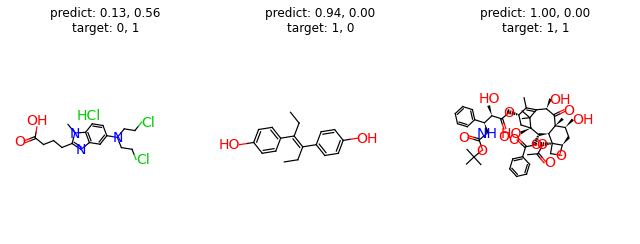

In [8]:
from torch.nn import functional as F

samples = []
categories = set()
for sample in valid_set:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)
samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = F.sigmoid(task.predict(samples))
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred = ", ".join(["%.2f" % p for p in pred])
    target = ", ".join(["%d" % t for t in target])
    titles.append("predict: %s\ntarget: %s" % (pred, target))
graph = samples["graph"]
graph.visualize(titles, figure_size=(3, 3.5), num_row=1)